In [2]:
import music21
import random
from music21 import note, chord, articulations

music_score_path = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'
music21.environment.set('musescoreDirectPNGPath', music_score_path)

# print(music21.environment.get('musicxmlPath'))
# print(music21.environment.get('musescoreDirectPNGPath'))


In [8]:
def write_fingering(f, onset, offset, name, beam):
    """
    Write fingering info to the file.
    
    f: File to write to.
    onset: Note start time.
    offset: Note end time.
    name: Note pitch (e.g., "C4").
    beam: 0 for right hand, 1 for left hand (negates finger number).
    """
    
    finger = random.randint(1, 5)
    if beam == 1:
        finger = -finger
    f.write(f"{0} {onset:.3f} {offset:.3f} {name} {0} {0} {beam} {finger}\n")

    
def Stream2PIG(sf, fname, beam=0, time_unit=0.5):
    """
    Convert a Stream to PIG format.
    
    sf: music21 Stream object.
    fname: Output file name.
    beam: 0 for right hand, 1 for left hand.
    time_unit: Time scaling factor.
    """
    
    with open(fname, 'w') as f:
        for elem in sf.flat.notesAndRests:
            onset = elem.offset * time_unit
            offset = (elem.offset + elem.quarterLength) * time_unit
            
            if isinstance(elem, note.Note):
                name = elem.nameWithOctave.replace('-', 'b')
                write_fingering(f, onset, offset, name, beam)
            elif isinstance(elem, chord.Chord):
                for pitch in elem.pitches:
                    name = pitch.nameWithOctave.replace('-', 'b')
                    write_fingering(f, onset, offset, name, beam)


In [11]:
def assign_finger(elem, fingerings, onset, offset, time_unit):
    """
    Assign fingering to notes/chords based on PIG data.
    
    elem: The note or chord to assign fingering.
    fingerings: List of fingering data from PIG file.
    onset: Start time of the note.
    offset: End time of the note.
    time_unit: Time scaling factor.
    """
    
    if isinstance(elem, note.Note):
        names_to_check = [elem.nameWithOctave.replace('-', 'b')]
    elif isinstance(elem, chord.Chord):
        names_to_check = [pitch.nameWithOctave.replace('-', 'b') for pitch in elem.pitches]
    else:
        return

    for fingering_data in fingerings:
        fingering_onset, fingering_offset, fingering_name, fingering_number = fingering_data
        for name in names_to_check:
            if abs(onset - fingering_onset) < 0.001 and abs(offset - fingering_offset) < 0.001:
                if name == fingering_name:
                    finger_articulation = articulations.Fingering(abs(fingering_number)) 
                    finger_articulation.placement = 'above'
                    elem.articulations.append(finger_articulation)

                    
def assign_fingers_from_pig(input_stream, pig_file, beam=0, time_unit=0.5):
    """
    Assign fingering to notes in a Stream based on PIG file.
    

    input_stream: music21 Stream object.
    pig_file: Path to the PIG text file.
    beam: 0 for right hand, 1 for left hand.
    time_unit: Time scaling factor.
    """
    
    fingerings = []
    with open(pig_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.split()
            if len(parts) == 8:
                onset, offset, name, channel, finger = parts[1], parts[2], parts[3], parts[6], parts[7]
                if int(channel) == beam:
                    if beam == 1:
                        finger = -int(finger)
                    fingerings.append((float(onset), float(offset), name, int(finger)))

    for elem in input_stream.flat.notesAndRests:
        onset = elem.offset * time_unit
        offset = (elem.offset + elem.quarterLength) * time_unit
        
        assign_finger(elem, fingerings, onset, offset, time_unit)

    return input_stream


In [12]:
def process_both_hands(input_file, pig_right, pig_left, output_file, time_unit=1.0):
    """
    Process both hands from the input music file using PIG files and 
    show the updated music sheet with fingerings.

    input_file: Path to the input music file.
    pig_right: Path to the right-hand PIG output file.
    pig_left: Path to the left-hand PIG output file.
    output_file: Path to save the updated music file with fingerings.
    time_unit: Conversion factor for timing units, default is 1.0.
    """
    
    bwv295 = music21.converter.parse(input_file)
    bwv295.measures(1, 2).show()
    bwv295.measures(1, 2).write('musicxml.png',f"./output/initial_{input_file.split('/')[2]}")
    
    right_hand = bwv295.parts[0]
    left_hand = bwv295.parts[1]

    Stream2PIG(right_hand, pig_right, beam=0, time_unit=time_unit)
    Stream2PIG(left_hand, pig_left, beam=1, time_unit=time_unit)

    updated_right_hand = assign_fingers_from_pig(right_hand, pig_right, beam=0, time_unit=time_unit)
    updated_left_hand = assign_fingers_from_pig(left_hand, pig_left, beam=1, time_unit=time_unit)

    updated_score = music21.stream.Score()
    updated_score.append(updated_right_hand)
    updated_score.append(updated_left_hand)

    updated_score.measures(1, 2).write('musicxml.png', f"./output/output_{input_file.split('/')[2]}")
    updated_score.measures(1, 2).show()


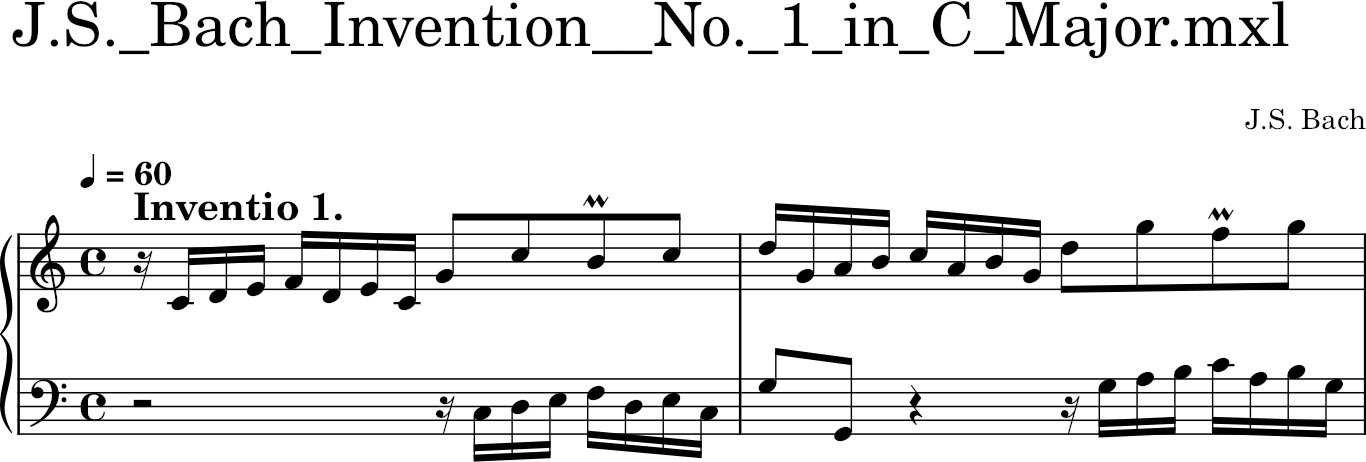

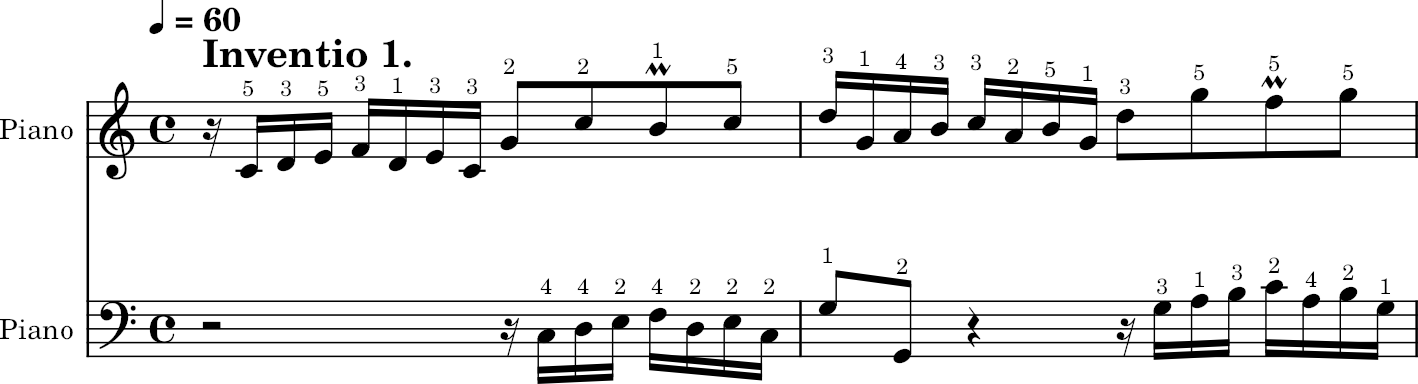

Both hands have been processed, and the file has been saved as 'updated_bach_with_fingers.xml'


In [13]:
process_both_hands('./music_files/J.S._Bach_Invention__No._1_in_C_Major.mxl', 
                   'output_right.txt', 'output_left.txt', 
                   'updated_bach_with_fingers.xml', time_unit=1.0)
print("Both hands have been processed, and the file has been saved as 'updated_bach_with_fingers.xml'")